# Clasificación de titulares de noticias

En este notebook, se axplora el proceso de clasificación de titulares de noticias en diversas categorías temáticas. El objetivo es desarrollar un modelo predictivo que pueda asignar una categoría a un titular dado, facilitando la organización y búsqueda de información. A lo largo de este notebook, se muestran los pasos desde la preparación inicial de los datos hasta la selección del modelo final.

Lo primero que se hace es cargar las librerías necesarias para llevar a cabo este proceso

In [39]:
#Librerías que se utilizaron a lo largo de este ejercicio

#Basicas para manipulación de datos
import pandas as pd
import numpy as np
import os
#Deshabilitación de warnings
import warnings
warnings.filterwarnings('ignore')

#Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

##Modelado
# Naive Bayes multinomial, regresión logistica
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#Vectorizador de texto de sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Label encoder
from sklearn.preprocessing import LabelEncoder
#Matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

#Precisión de modelo
from sklearn.metrics import accuracy_score

#División de datos
from sklearn.model_selection import train_test_split

#Smote para remuestreo
from imblearn.over_sampling import SMOTE

# Pipeline
from sklearn.pipeline import Pipeline
#PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Similitud entre vectores
from sklearn.metrics.pairwise import cosine_similarity


#Tratamiento de texto
import re
import string
import unicodedata
#Librería para Procesamiento de Lenguaje natural (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Descargar recursos de NLTK
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except:
    nltk.download('omw-1.4')
try:
    nltk.data.find('corpora/punkt_tab')
except:
    nltk.download('punkt_tab')

#Modulo para descargar modelo geneerado por sklearn
import pickle

#Librerías para crear redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [40]:
#Carga de información desde archivo json
df = pd.read_json('data.json')

df.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


## Limpieza de datos
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            color: #333;
            margin: 20px;
            background-color: #f4f4f4;
        }
        .container {
            max-width: 800px;
            margin: auto;
            background: #fff;
            padding: 30px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        h2 {
            color: #2c3e50;
            border-bottom: 2px solid #3498db;
            padding-bottom: 10px;
            margin-bottom: 20px;
        }
        strong {
            color: #e74c3c;
        }
        ul {
            list-style-type: disc;
            margin-left: 20px;
        }
        li {
            margin-bottom: 10px;
        }
    </style>
</head>
<body>
    <div class="container">
        <p>En el Procesamiento del Lenguaje Natural (PLN), la <strong>limpieza de datos</strong> es un proceso fundamental que busca estandarizar y refinar el texto para mejorar la calidad del análisis y el rendimiento de los modelos.</p>
        <p>Esta limpieza incluye:</p>
        <ul>
            <li><strong>Lematización</strong>: Un proceso donde las palabras se reducen a su <strong>forma base o raíz lingüística (lema)</strong>. Esto significa que diferentes variaciones de una misma palabra, como "corriendo", "corrió" o "correrá", se unifican a su forma base <strong>"correr"</strong>.</li>
            <li><strong>Eliminación de <em>stopwords</em></strong>: Se quitan palabras muy comunes (o "vacías") que, por sí mismas, aportan poco o nulo significado semántico a una oración, como los pronombres.</li>
            <li><strong>Eliminación de caracteres especiales</strong>: Se remueven símbolos, signos de puntuación, números y otros caracteres no alfanuméricos que pueden introducir ruido en el análisis.</li>
        </ul>
        <p>Al aplicar estas técnicas, se reduce el ruido y se normalizan los datos, lo que permite a los modelos de PLN concentrarse en la información más relevante y, en consecuencia, mejorar su precisión.</p>
    </div>
</body>

In [41]:
#Cargamos dataset con stopwords
english_stopwords = set(stopwords.words('english'))
#Cargamos objeto que permite lematizado
lemmatizer = WordNetLemmatizer()

#Creamos función para limpiar instancias
def clean_text_for_modeling(text):
    """
    Limpia un string de texto para preparar datos para modelado
    """
    # 1. Convertir a minúsculas, como parte de la estandarización
    text = text.lower()

    # 2. Eliminar URLs y patrones comunes en redes sociales
    text = re.sub(r'https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'\brt\b', '', text)


    # 3. Eliminar puntuación y números
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text) # Eliminar números

    # 4. Normalizar caracteres Unicode (acentos, ñ, etc.)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # 5. Tokenizar el texto
    tokens = word_tokenize(text)

    # 6. Eliminar stopwords y lematizar
    cleaned_tokens = []
    for word in tokens:
        if word not in english_stopwords and word.strip() != '':
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    # 7. Eliminamos las palabras 'photo', 'new', 'video'
    #Dado que se observan como de las más comunes en multiples categorias
    cleaned_tokens = [word for word in cleaned_tokens if word != 'new']
    cleaned_tokens = [word for word in cleaned_tokens if word != 'photo']
    cleaned_tokens = [word for word in cleaned_tokens if word != 'video']

    # 8. Unir las palabras limpias de nuevo en un string
    text_cleaned = ' '.join(cleaned_tokens)
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned).strip() # Eliminar espacios extra

    return text_cleaned

print("Limpiando la columna 'headline'...")
# Aplica la función de limpieza a la columna 'headline'
df['headline_cleaned'] = df['headline'].apply(clean_text_for_modeling)

#Eliminamos registros donde hay 0 palabras en headline_cleaned
df = df[df['headline_cleaned'].apply(lambda x: len(x.split())) > 0]

df.head()

Limpiando la columna 'headline'...


,headline,category,headline_cleaned
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,million american roll sleeve omicrontargeted c...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,american airline flyer charged banned life pun...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,funniest tweet cat dog week sept
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,funniest tweet parent week sept
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,woman called cop black birdwatcher loses lawsu...


## Análisis exploratorio de datos

El análisis exploratorio es importante, pues permite comprender las características principales de los datoss que se analizan.
Para este caso que se trata de clasificación de texto, podríamos:

* Analizar la distribución de instancias por categoría
* Explorar la logitud de los textos
* Analizar datos faltanes

  


In [42]:
#Primero revisamos el númeroi de datos faltanres por cada campo
df.isnull().sum()

,0
headline,0
category,0
headline_cleaned,0


In [43]:
print('Número de categorías')
print(df['category'].nunique())

print('Total de registros')
print(len(df))

Número de categorías
42
Total de registros
209455


En este caso no se encuentran valores nulos, y podemos ver que nuestro dataset consta de 209,457 registros, los cuales están segmentados en 42 categorías

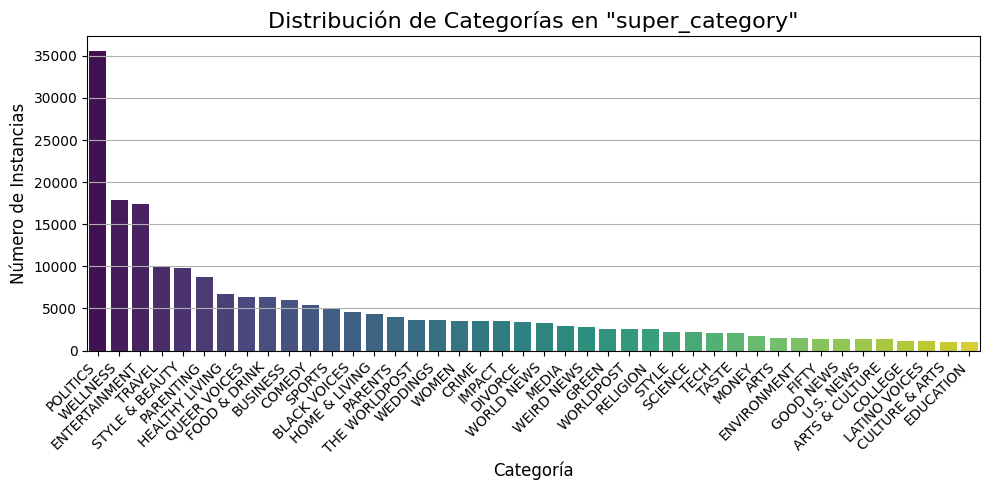

,count
category,
POLITICS,35598
WELLNESS,17926
ENTERTAINMENT,17361
TRAVEL,9900
STYLE & BEAUTY,9813
PARENTING,8778
HEALTHY LIVING,6690
QUEER VOICES,6342
FOOD & DRINK,6340


In [44]:
#Mostramos el número de isntancias por cada valor de super_category
category_counts = df['category'].value_counts()


plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribución de Categorías en "super_category"', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de Instancias', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

category_counts

Como se observa en la gráfica anterior, el conjunto de datos presenta un severo desbalance de clases. Algunas categorías dominan con aproximadamente 35,000 instancias, lo que representa cerca del 16% del total de registros, mientras que otras categorías minoritarias apenas superan las 1,000 instancias.

Cuando se entrena un modelo de Machine Learning con un dataset tan desequilibrado, existe un alto riesgo de sobreajuste (overfitting) hacia las clases mayoritarias. El modelo, al disponer de una abundancia de ejemplos de estas clases, no "observa" suficientes patrones de las categorías minoritarias, lo que dificulta su capacidad para generalizar correctamente las relaciones subyacentes y hacer predicciones precisas sobre estas últimas.

Para abordar este problema, existen varias técnicas de remuestreo. Una opción es el submuestreo de la clase mayoritaria, que consiste en reducir el número de observaciones de las clases dominantes para acercarlas al tamaño de las minoritarias. Sin embargo, esta técnica puede llevar a la pérdida de información valiosa para el modelo.

Una alternativa más robusta es el sobremuestreo (oversampling) de las clases minoritarias. Este método genera observaciones sintéticas a partir de las instancias existentes de las categorías con menos registros. Así, se logra un conjunto de datos más equilibrado, donde todas las clases tienen un número de instancias más similar, permitiendo que el modelo aprenda de manera más equitativa de cada una de ellas.

Antes de proceder con la propuesta y ajuste de modelos, es crucial abordar un problema de redundancia de clases en el conjunto de datos. Es posible que las categorías provengan de diferentes fuentes o criterios de etiquetado, lo que ha generado duplicados o conceptos superpuestos.

Por ejemplo, categorías como "Art", "Art & Culture" y "Culture & Art" claramente engloban la misma idea central, a pesar de sus variaciones nominales. De manera similar, se observan redundancias en "The WorldSpot" y "WordSpot".

Para resolver esta cuestión, tenemos dos caminos:

Podríamos colapsar manualmente algunas de estas variables basándonos en nuestra interpretación del dominio y la relevancia conceptual.

Alternativamente, podemos recurrir a técnicas más sofisticadas como los **embeddings**, que permiten agrupar semánticamente categorías similares de una manera más objetiva y basada en datos.

En el contexto del Procesamiento del Lenguaje Natural (PLN), los embeddings son representaciones numéricas de elementos lingüísticos, tales como palabras, frases o documentos completos, dentro de un espacio vectorial de baja dimensionalidad. Este enfoque transforma cada elemento textual en un punto en un espacio multidimensional, donde la proximidad y la dirección entre dichos puntos capturan sus relaciones semánticas y sintácticas. En esencia, palabras con significados similares o que coaparecen en contextos parecidos se ubicarán cerca unas de otras en este espacio. Por ejemplo, en un embedding bien entrenado, las palabras "rey" y "reina" mostrarían una cercanía vectorial análoga a la observada entre "hombre" y "mujer".

Para abordar este desafío, se empleó un embedding público pre-entrenado proporcionado por Stanford (GloVe). Esta herramienta permite transformar los nombres de las categorías en vectores numéricos (Vectores de dimensión 300), que luego pueden ser proyectados a un espacio vectorial de menor dimensionalidad (por ejemplo, bidimensional) para su visualización. En este espacio, la proximidad entre los puntos representará la similitud semántica entre las categorías, facilitando la identificación y posterior consolidación de aquellas con conceptos redundantes o muy cercanos.

In [11]:
#Descargamos el ambeding público.

embeddings_dir = 'embeddings'
os.makedirs(embeddings_dir, exist_ok=True)

#Carga de embedings
if not os.path.exists(os.path.join(embeddings_dir, 'glove.6B.zip')):
    !wget -P {embeddings_dir} http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists(os.path.join(embeddings_dir, 'glove.6B.300d.txt')):
    !unzip {embeddings_dir}/glove.6B.zip -d {embeddings_dir}
embedding_file_path = os.path.join(embeddings_dir, 'glove.6B.300d.txt')
embedding_dim = 300
print(f"GloVe embeddings disponibles en: {embedding_file_path}")


#Carga de embedings
print(f"\nCargando embeddings pre-entrenados desde: {embedding_file_path}")
embeddings_index = {}
try:
    with open(embedding_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Cargados {len(embeddings_index)} vectores de palabras.")
except FileNotFoundError:
    print(f"ERROR: El archivo de embeddings '{embedding_file_path}' no se encontró. No se pueden generar los embeddings de categoría.")
    embeddings_index = None
except Exception as e:
    print(f"ERROR: Ocurrió un error al cargar el archivo de embeddings: {e}. No se pueden generar los embeddings de categoría.")
    embeddings_index = None



--2025-07-28 02:28:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-28 02:28:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-28 02:28:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘embeddings/glove.6B

In [46]:
#Una vez descargado el embeding, estandarizamos los nombres de las categorías
df['category'] = df['category'].str.strip().str.lower() # Normalizar categorías

#Limpieza de palabras stopper y lematización
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto_eng_simple(texto):
    """
    Versión simplificada de limpieza para nombres de categorías.
    Elimina puntuación, números, normaliza y tokeniza. No elimina stopwords
    porque pueden ser importantes en nombres de categorías (ej. 'arts & culture').
    """
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'&[a-z]+;', '', texto) # Quita entidades HTML como &amp;
    texto = texto.translate(str.maketrans('', '', string.punctuation + string.digits))
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    tokens = word_tokenize(texto)
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lematiza
    texto_limpio = ' '.join(tokens)
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    return texto_limpio



No se encontraron embeddings para 'worldpost' (limpio: 'worldpost')

Generados 42 vectores para las categorías, de dimensión 300.

Reducida la dimensionalidad con PCA a 41 componentes. Varianza explicada: 1.00

Aplicando t-SNE para reducir la dimensionalidad a 2D...

Visualizando clusters de categorías:


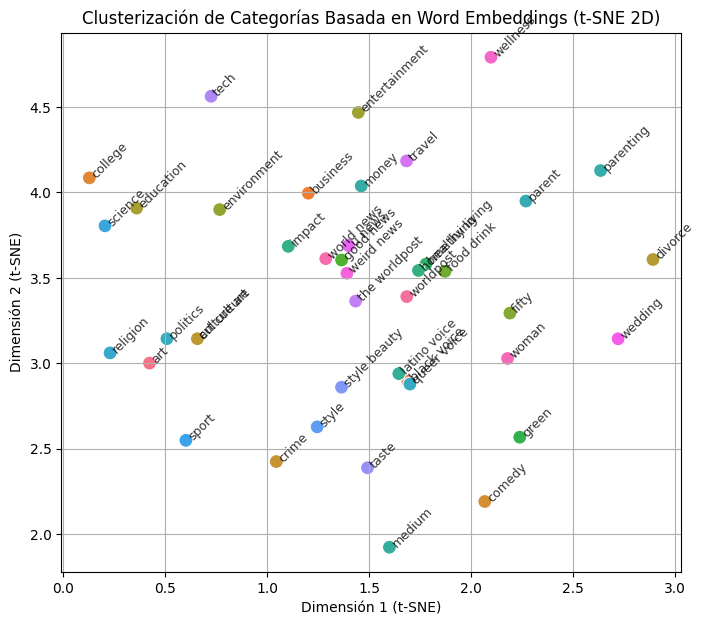

In [13]:
# Generamos embedings para cada categoría.
if embeddings_index:
    unique_categories = sorted(df['category'].unique())
    category_vectors = []
    category_names_cleaned = []

    for category_name in unique_categories:
        cleaned_name = limpiar_texto_eng_simple(category_name)
        category_names_cleaned.append(cleaned_name)
        words = cleaned_name.split()
        vectors_for_category = []
        for word in words:
            if word in embeddings_index:
                vectors_for_category.append(embeddings_index[word])
            # else: Si la palabra no está en los embeddings, se ignora

        if vectors_for_category:
            # Promedia los vectores de las palabras para obtener un vector de categoría
            category_vector = np.mean(vectors_for_category, axis=0)
            category_vectors.append(category_vector)
        else:
            # Si ninguna palabra del nombre de la categoría tiene embedding, usa un vector de ceros
            print(f"No se encontraron embeddings para '{category_name}' (limpio: '{cleaned_name}')")
            category_vectors.append(np.zeros(embedding_dim))

    category_vectors = np.array(category_vectors)
    print(f"\nGenerados {category_vectors.shape[0]} vectores para las categorías, de dimensión {category_vectors.shape[1]}.")

    # Crear un DataFrame base para las categorías
    category_df = pd.DataFrame({'category': unique_categories, 'cleaned_category': category_names_cleaned})

    #Reducción de dimensionalidad mediante analicis de componentes principales
    n_components_pca_for_tsne = min(50, len(category_vectors) - 1)

    if n_components_pca_for_tsne > 0:
        pca_pre_tsne = PCA(n_components=n_components_pca_for_tsne, random_state=42)
        reduced_vectors = pca_pre_tsne.fit_transform(category_vectors)
        print(f"\nReducida la dimensionalidad con PCA a {n_components_pca_for_tsne} componentes. Varianza explicada: {pca_pre_tsne.explained_variance_ratio_.sum():.2f}")
    else:
        # Si hay muy pocas categorías para PCA (ej. solo 1), no se aplica PCA y se usan los vectores originales
        print("\nDemasiado pocas categorías para PCA (N <= 1). Usando vectores originales.")
        reduced_vectors = category_vectors


    print("\nAplicando t-SNE para reducir la dimensionalidad a 2D...")
    perplexity_val_tsne = min(30, len(reduced_vectors) - 1)
    if perplexity_val_tsne <= 1:
        print("Demasiado pocas categorías para t-SNE o perplexity inválida. No se puede generar gráfico t-SNE.")
    else:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val_tsne)
        category_vectors_2d = tsne.fit_transform(reduced_vectors) # Aquí se usa reduced_vectors, la salida del PCA

        # Crear un DataFrame para la visualización
        # Aseguramos que el tamaño de category_vectors_2d sea el mismo que unique_categories
        if len(category_vectors_2d) == len(unique_categories):
            category_df['tsne_dim1'] = category_vectors_2d[:, 0]
            category_df['tsne_dim2'] = category_vectors_2d[:, 1]

            print("\nVisualizando clusters de categorías:")
            plt.figure(figsize=(8, 7))
            sns.scatterplot(x='tsne_dim1', y='tsne_dim2', hue='category', data=category_df, legend=False, s=100)

            # Añadir etiquetas de texto a los puntos para identificar las categorías
            for i, row in category_df.iterrows():
                #Mostramos el texto rotado 45 grados
                plt.text(row['tsne_dim1'] , row['tsne_dim2'], row['cleaned_category'], fontsize=9, alpha=0.8, rotation=45)
                #plt.text(row['tsne_dim1'] + 0.1, row['tsne_dim2'], row['category'], fontsize=9, alpha=0.8)

            plt.title('Clusterización de Categorías Basada en Word Embeddings (t-SNE 2D)')
            plt.xlabel('Dimensión 1 (t-SNE)')
            plt.ylabel('Dimensión 2 (t-SNE)')
            plt.grid(True)
            #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            #plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta el rectángulo de la figura para dejar espacio a la leyenda
            plt.show()
        else:
            print("Error: El número de vectores 2D de t-SNE no coincide con el número de categorías únicas.")
            print(f"Num t-SNE vectors: {len(category_vectors_2d)}, Num unique categories: {len(unique_categories)}")
else:
  print("Error: No se pudieron generar los embeddings de categoría debido a un error en la carga de los embeddings pre-entrenados.")


## Reorganización de clases

En esta grafica podemos notar que efectivamente hay clases que incluso se sobrebonen como *art & culture* y *culture & art*, por lo que son podemos usarla para colapsar campos.

Se analizó y clusterizaron las categorías de noticias utilizando embeddings para identificar agrupaciones semánticas. Después de explorar distintas configuraciones de clusters, se proponen las siguientes supercategorías para una mejor organización de los titulares:

**1. Money**

    * Business
    * Money

**2. Voices**

    * Black Voices
    * Latino Voices
    * Queer Voices
    * Women

**3. News**

    * Good News
    * Impact
    * U.S. News
    * Weird News
    * World News
    * WorldPost
    * The WorldPost

**4. Style**

    * Style
    * Style & Beauty

**5. Living**

    * Environment
    * Healthy Living
    * Home & Living

**6. Arts**

    * Arts
    * Arts & Culture
    * Culture & Arts

**7. science**

    * College
    * Education
    * Science
    * Tech

**8. Food**

    * Food & Drink
    * Taste

**9. Politics & Religion**

    * Politics
    * Religion

**10. Parenting**

    * Parenting
    * Parents

**11. Media**

    * Media
    * Entretainment
    * Comedy


El resto de categorías no se agruparon y permanecen sin cambios


In [ ]:
# categorías agrupadas
super_category_map = {
    # 1. Money
    'business': 'money',
    'money': 'money',

    # 2. Voices
    'black voices': 'voices',
    'latino voices': 'voices',
    'queer voices': 'voices',
    'women': 'voices',

    # 3. News
    'good news': 'news',
    'impact': 'news', 
    'u.s. news': 'news',
    'weird news': 'news',
    'world news': 'news',
    'worldpost': 'news',
    'the worldpost': 'news',

    # 4. Style
    'style': 'style',
    'style & beauty': 'style',

    # 5. Living
    'environment': 'living',
    'healthy living': 'living',
    'home & living': 'living',
    'fifty': 'living',

    # 6. Arts
    'arts': 'arts',
    'arts & culture': 'arts',
    'culture & arts': 'arts',

    # 7. Science
    'college': 'science',
    'education': 'science',
    'science': 'science',
    'tech':'science',

    # 8. Food
    'food & drink': 'Food',
    'taste': 'Food',

    # 9. Politics & Religion
    'politics': 'politics & religion',
    'religion': 'politics & religion',

    #10. Parenting
    'parenting': 'parenting',
    'parents': 'parenting',

    #11. Media
    'media': 'media',
    'entertainment': 'media',
    'comedy': 'media'
}

df['super_category'] = df['category'].map(super_category_map).fillna(df['category'])

print("Número de categorías finales")
print(df['super_category'].nunique())

#Validamos algunas aleatorias
print("\nEjemplo de mapeo de categorías a supercategorías:")
df.sample(10)

Número de categorías finales
18

Ejemplo de mapeo de categorías a supercategorías:


,headline,category,headline_cleaned,super_category
17718,Has Everyone Given Up On Gun Violence In Chicago?,politics,everyone given gun violence chicago,politics & religion
206691,Weddings 2012: Six Original Party Favours That...,weddings,wedding six original party favour delight even...,weddings
134908,The Least Obese U.S. Metro Area Is...,wellness,least obese u metro area,wellness
51858,Turkey's Treatment Of Purged Officials Reminis...,the worldpost,turkey treatment purged official reminiscent n...,news
106316,The Big Smooch: Start the New Year With a Movi...,entertainment,big smooch start year movie kiss,media
5234,"Founder Of Trader Joe's Markets, Joe Coulombe,...",u.s. news,founder trader joes market joe coulombe dy,news
47512,Cuba Bans Naming Statues Or Public Places Afte...,the worldpost,cuba ban naming statue public place fidel castro,news
67635,Unauthorized Angela Davis Biopic By ‘Shameless...,black voices,unauthorized angela davis biopic shameless scr...,voices
120481,Is The Federal Reserve Printing A Free Lunch?,business,federal reserve printing free lunch,money
143520,How Sleep Deprivation Decays The Mind And Body,wellness,sleep deprivation decay mind body,wellness


In [48]:
#Mostramos el número de isntancias por cada valor de super_category
print('Numero de valores nulos por columna')
print(df.isnull().sum())
print('-'*100)
print('Numero de valores vacios ('') por columna')
print(df.eq('').sum())
print('-'*100)

print('Número de instancias por super_category')
df['super_category'].value_counts()

Numero de valores nulos por columna
headline            0
category            0
headline_cleaned    0
super_category      0
dtype: int64
----------------------------------------------------------------------------------------------------
Numero de valores vacios () por columna
headline            0
category            0
headline_cleaned    0
super_category      0
dtype: int64
----------------------------------------------------------------------------------------------------
Número de instancias por super_category


,count
super_category,
politics & religion,38172
media,25700
news,18576
wellness,17926
voices,15623
living,13854
parenting,12729
style,12067
travel,9900


Como puede verse en la tabla anterior, el problema de desbalance de clases sigue presente, pues ahora la clase predominante tiene 38,172 registros, mientras que la clase minoritaria cuenta con 2,621 instancias.



## Preparación de datos

Los modelos de Machine Learning, por su naturaleza, requieren datos numéricos para su entrenamiento. Esto significa que tanto las características de entrada como sus correspondientes etiquetas deben estar representadas en un formato vectorial. En el contexto del Procesamiento del Lenguaje Natural (PLN), donde la entrada son textos (en este caso, titulares limpios), es esencial transformar estas cadenas de texto en un formato numérico comprensible para el algoritmo.

Para lograr esta vectorización del texto, se utilizó el TfidfVectorizer. Esta herramienta convierte una colección de documentos de texto en una matriz de características TF-IDF. Cada fila de esta matriz representa un titular y cada columna corresponde a una palabra del vocabulario, con el valor de la celda indicando la importancia de esa palabra en el titular respecto a todo el corpus de documentos. De esta forma, los titulares son transformados en los vectores numéricos requeridos para alimentar el modelo de Machine Learning.

Para poder transformar esta categoría textual en un valor numérico que los modelos de Machine Learning puedan procesar, se emplea un proceso de codificación de etiquetas (Label Encoding). Este consiste en asignar un número entero único a cada categoría nominal distinta. Por ejemplo, si tenemos las categorías "Deportes", "Política" y "Economía", el codificador podría asignarles los valores 0, 1 y 2 respectivamente. Este mapeo permite que el modelo trabaje con las categorías de manera cuantitativa.

In [49]:
#Separamos los datos que se van a usar para entrenar al modelo
#(Titulares limpios) y aplicamos label encoder a las categorias
X = df['headline_cleaned']
y = df['super_category']

#Label encoder
le = LabelEncoder()
y = le.fit_transform(y)
# Mapeo inverso para entender los resultados
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"Número de supercategorías únicas: {len(le.classes_)}")
print('-'*100)
print(f"Mapeo de etiquetas:")
for label, category in label_mapping.items():
    print(f"{label}: {category}")
print('-'*100)



Número de supercategorías únicas: 18
----------------------------------------------------------------------------------------------------
Mapeo de etiquetas:
0: Food
1: arts
2: crime
3: divorce
4: green
5: living
6: media
7: money
8: news
9: parenting
10: politics & religion
11: science
12: sports
13: style
14: travel
15: voices
16: weddings
17: wellness
----------------------------------------------------------------------------------------------------


In [50]:
#Mostramos las tres palabras más comunes en las instancias de cada clase
for category in np.unique(df['super_category']):
  print(f"Palabras más comunes en titulares de la categoría '{category}':")
  df_restringido = df[df['super_category'] == category]
  vectorizer = CountVectorizer()
  X_restringido = vectorizer.fit_transform(df_restringido['headline_cleaned'])
  sum_words = X_restringido.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  for word, freq in words_freq[:5]:
    print(f"{word}: {freq}")
  print('-'*100)


Palabras más comunes en titulares de la categoría 'Food':
recipe: 1431
food: 817
best: 620
make: 578
day: 444
----------------------------------------------------------------------------------------------------
Palabras más comunes en titulares de la categoría 'arts':
art: 506
artist: 336
book: 159
world: 124
woman: 116
----------------------------------------------------------------------------------------------------
Palabras más comunes en titulares de la categoría 'crime':
police: 478
man: 447
cop: 306
shooting: 303
say: 219
----------------------------------------------------------------------------------------------------
Palabras más comunes en titulares de la categoría 'divorce':
divorce: 1359
marriage: 247
ex: 180
divorced: 168
single: 148
----------------------------------------------------------------------------------------------------
Palabras más comunes en titulares de la categoría 'green':
climate: 342
change: 193
dog: 148
california: 123
trump: 73
---------------------

In [51]:
#Dividimos en datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y) #Con este parametro
                                                    #Aseguramos que la proporción
                                                    # de clases permanezca en
                                                    # conjuntos de prueba y validacion

#Dado que el vocabulario inlges es muy extenso, si hacemos un vectorizado de
# los titulares, donde cada entrada representa la cantidad de observaciones de una palabra
# necesitariamos un vector tan extenso, como el número de palabras en el vocabulario
# lo cuál sería demasiado grande, por lo que se debe establecer, un límite, para
# que este vectorizado solo utilize las n palabras más observadas en los titulares
#Número máximo de palabras a considerar
max_features = 10000
#Numero minimo de repeticiones necesarias para ignorar palabras poco comunes
min_df = 7
tfidf_vectorizer = TfidfVectorizer(max_features=max_features,
                                   min_df=min_df)

#Vectorizado
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#Mostramos dimensionalidad de datos de entrenamiento
print(f"Dimensiones de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print('-'*100)

#Aplicación de SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

print('Conteo de clases después del SMOTE:')
pd.Series(y_train_resampled).value_counts()



Dimensiones de X_train_tfidf: (167564, 10000)
Dimensiones de y_train: (167564,)
----------------------------------------------------------------------------------------------------
Conteo de clases después del SMOTE:


,count
6,30538
5,30538
10,30538
3,30538
1,30538
12,30538
13,30538
17,30538
15,30538
14,30538


Como puede observarse, después del remuestreo, ahora contamos con un conjunto de entrenamiento que, si bien incluye instancias sintéticas, presenta un número equilibrado de registros para cada categoría.

El primer modelo que entrenameros será un modelo Naive-Bayes ya que podría ser adecuado para este problema de clasificación de texto porque se basa en un enfoque de conteo de ocurrencias, que encaja naturalmente con la forma en que se representan los datos textuales. Las entradas al modelo son vectores numéricos que esencialmente contienen el número de veces que ciertas palabras aparecen en un documento. Este modelo utiliza estas frecuencias para calcular la probabilidad de que un documento pertenezca a una categoría específica, asumiendo la independencia entre las palabras. Su simplicidad y eficiencia lo hacen un punto de partida robusto y efectivo para tareas de clasificación de texto

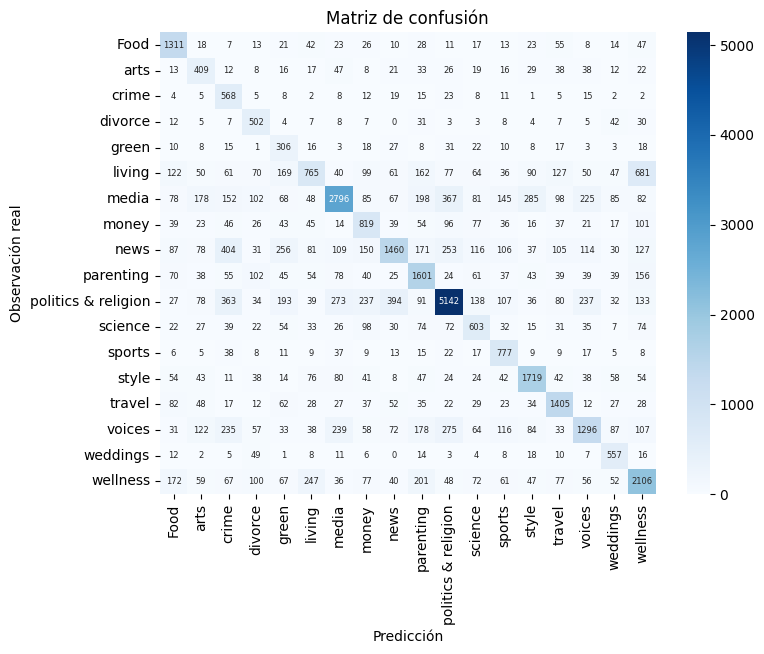

Reporte de clasificación:
                     precision    recall  f1-score   support

               Food       0.61      0.78      0.68      1687
               arts       0.34      0.52      0.41       784
              crime       0.27      0.80      0.40       713
            divorce       0.43      0.73      0.54       685
              green       0.22      0.58      0.32       524
             living       0.49      0.28      0.35      2771
              media       0.73      0.54      0.62      5140
              money       0.45      0.53      0.49      1549
               news       0.62      0.39      0.48      3715
          parenting       0.54      0.63      0.58      2546
politics & religion       0.79      0.67      0.73      7634
            science       0.42      0.47      0.44      1294
             sports       0.49      0.77      0.60      1015
              style       0.69      0.71      0.70      2413
             travel       0.63      0.71      0.67      19

In [52]:
#Modelo Naive-Bayes
nb = MultinomialNB(alpha=5)
nb.fit(X_train_resampled, y_train_resampled)
y_pred = nb.predict(X_test_tfidf)

#Matriz de confusión
mc = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mc, annot=True,
            fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot_kws={"fontsize": 6})
#Añadimos labs de predicción y observación real
plt.xlabel('Predicción')
plt.ylabel('Observación real')
plt.title('Matriz de confusión')
plt.show()

#Reporte
print("Reporte de clasificación:")
#Mostramos reporte como un dataframe
print(classification_report(y_test, y_pred, target_names=le.classes_))


Tambien se probó con un modelo de regresión logística

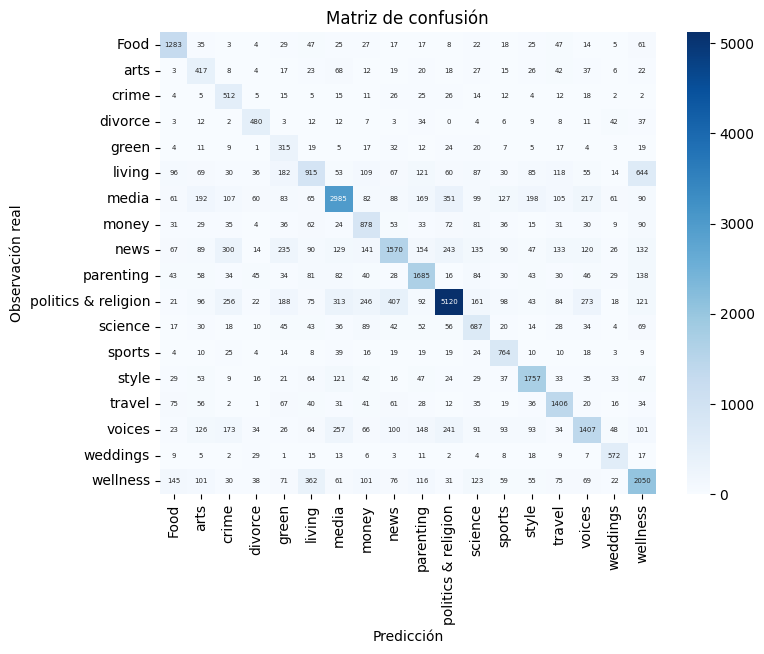

Reporte de clasificación:
                     precision    recall  f1-score   support

               Food       0.67      0.76      0.71      1687
               arts       0.30      0.53      0.38       784
              crime       0.33      0.72      0.45       713
            divorce       0.59      0.70      0.64       685
              green       0.23      0.60      0.33       524
             living       0.46      0.33      0.38      2771
              media       0.70      0.58      0.63      5140
              money       0.45      0.57      0.50      1549
               news       0.60      0.42      0.50      3715
          parenting       0.61      0.66      0.63      2546
politics & religion       0.81      0.67      0.73      7634
            science       0.40      0.53      0.45      1294
             sports       0.52      0.75      0.62      1015
              style       0.71      0.73      0.72      2413
             travel       0.63      0.71      0.67      19

In [53]:
#Modelo Regresión logística
lr = LogisticRegression(max_iter=1000,
                        class_weight = 'balanced',C=0.2,
                        random_state=42,penalty='l2')
lr.fit(X_train_resampled, y_train_resampled)
y_pred = lr.predict(X_test_tfidf)

#Matriz de confusión
mc = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(mc, annot=True,
            fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot_kws={"fontsize": 5})
#Añadimos labs de predicción y observación real
plt.xlabel('Predicción')
plt.ylabel('Observación real')
plt.title('Matriz de confusión')
plt.show()

#Reporte
print("Reporte de clasificación:")
#Mostramos reporte como un dataframe
print(classification_report(y_test, y_pred, target_names=le.classes_))

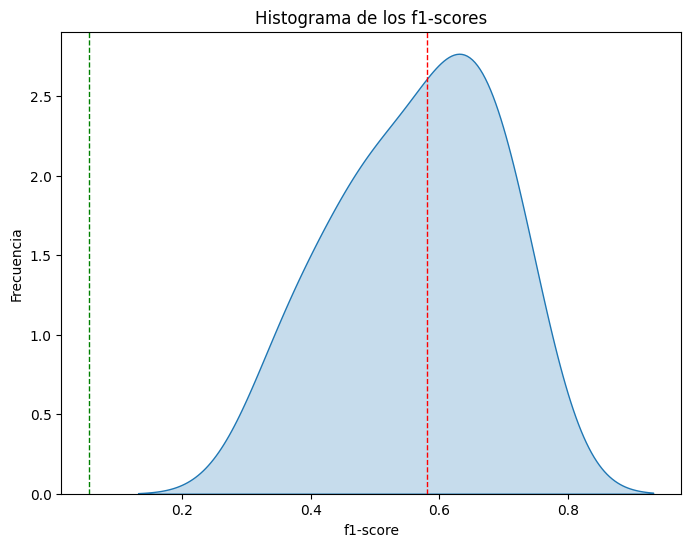

In [91]:
#enlistamos los f1-scores de todas las clases
f1_scores = np.array([])
for i,j in classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True).items():
  try:
    f1_scores = np.append(f1_scores,j['f1-score'])
  except:
    pass

#Graficamos histograma de los f1-scores
plt.figure(figsize=(8,6))
#plt.hist(f1_scores, bins=30, edgecolor='black')
#Funsión de densidad aproximada
sns.kdeplot(f1_scores, shade=True)
#Línea vertical sobre mediana
plt.axvline(np.median(f1_scores), color='r', linestyle='dashed', linewidth=1)
#Linea vertical
plt.axvline(1/18, color='g', linestyle='dashed', linewidth=1)
plt.title('Histograma de los f1-scores')
plt.xlabel('f1-score')
plt.ylabel('Frecuencia')
plt.show()


Podemos observar un aproximado de la distribución de los f1-scores de cada clase.

Tambien probamos entrenar una red neuronal para ver si esta es mejor clasificando los encabezados.

Epoch 1/50
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3829 - loss: 2.0423
Epoch 1: val_loss improved from inf to 1.57181, saving model to best_nn_model_sparse_data.keras
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 271s 16ms/step - accuracy: 0.3829 - loss: 2.0423 - val_accuracy: 0.5423 - val_loss: 1.5718
Epoch 2/50
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5952 - loss: 1.4086
Epoch 2: val_loss did not improve from 1.57181
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.5952 - loss: 1.4086 - val_accuracy: 0.5566 - val_loss: 1.5721
Epoch 3/50
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6344 - loss: 1.2790
Epoch 3: val_loss did not improve from 1.57181
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.6344 - loss: 1.2790 - val_accuracy: 0.5601 - val_loss: 1.6400
Epoch 4/50
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6528 - loss: 1.2093
Epoch 4: val_loss did not improve from 1.57181
17178/17178 ━━━━━━━━━━━━━━━━━━━━ 4

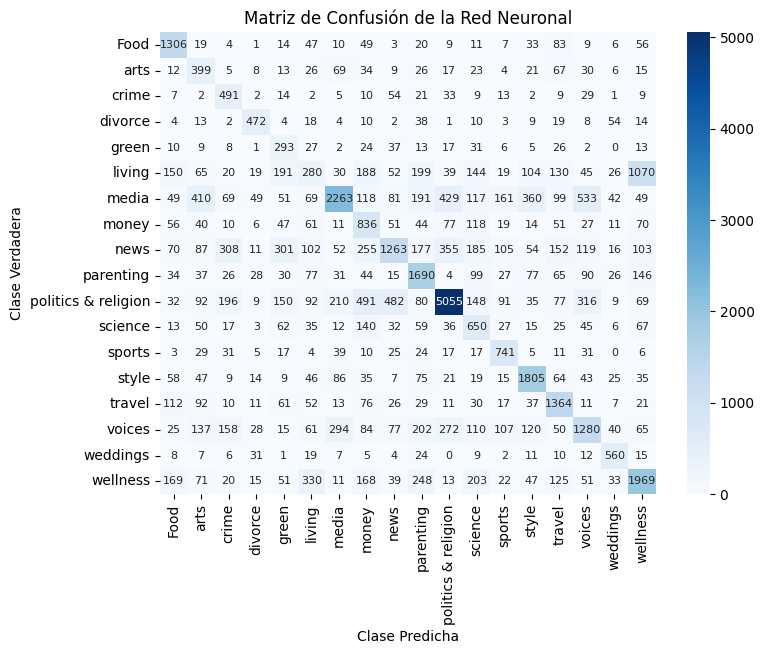

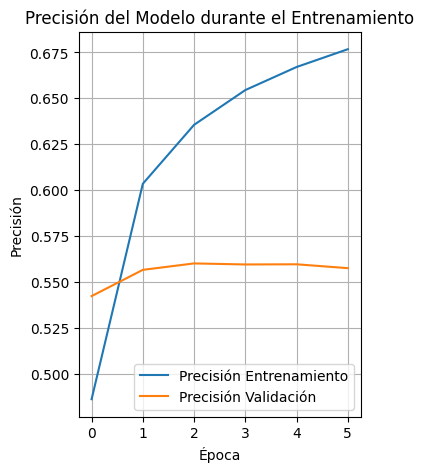

In [32]:
df_model = df[df['headline_cleaned'].str.strip() != ''].copy()

X = df_model['headline_cleaned']
y = df_model['super_category']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Vectorización TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#Smothe
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)

input_dim_nn = X_train_resampled.shape[1]


#Creamos la red
model = Sequential([
    # Primera capa oculta
    Dense(128, activation='relu', input_shape=(input_dim_nn,)),
    Dropout(0.5),

    # Segunda capa oculta
    Dense(64, activation='relu'),
    Dropout(0.5),

    #Tercer capa
    Dense(32, activation='relu'),
    Dropout(0.5),

    # Capa de salida
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Se entrena
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitorea la pérdida de validación
    patience=5,         # Espera 5 épocas sin mejora antes de detenerse
    restore_best_weights=True # Restaura los pesos del mejor epoch
)

# ModelCheckpoint: Guarda el mejor modelo durante el entrenamiento
model_checkpoint = ModelCheckpoint(
    'best_nn_model_sparse_data.keras', # Nombre del archivo para guardar el modelo
    monitor='val_loss',     # Monitorea la pérdida de validación
    save_best_only=True,    # Solo guarda el mejor modelo encontrado
    mode='min',             # Queremos minimizar la pérdida
    verbose=1
)

history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50, # Puedes empezar con más épocas; EarlyStopping lo detendrá
    batch_size=32, # Tamaño del lote (puedes ajustar)
    validation_data=(X_test_tfidf, y_test_encoded), # Los datos de prueba también son dispersos
    callbacks=[early_stopping, model_checkpoint], # Usar los callbacks
    verbose=1 # Mostrar progreso
)

loss, accuracy = model.evaluate(X_test_tfidf, y_test_encoded, verbose=0)

y_pred_proba = model.predict(X_test_tfidf)
y_pred_encoded = np.argmax(y_pred_proba, axis=1) # Convertir probabilidades a etiquetas de clase

y_test_original_labels = le.inverse_transform(y_test_encoded)
y_pred_original_labels = le.inverse_transform(y_pred_encoded)

print("\n--- Reporte de Clasificación de la Red Neuronal ---")
print(classification_report(y_test_original_labels, y_pred_original_labels))


print("\n--- Matriz de Confusión de la Red Neuronal ---")
conf_matrix_nn = confusion_matrix(y_test_original_labels, y_pred_original_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"fontsize": 8})
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión de la Red Neuronal')
plt.show()

### 8. Gráficas de Entrenamiento

plt.figure(figsize=(8, 5))

# Gráfica de Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

Aunque a primera vista los modelos podrían parecer de bajo rendimiento debido a una precisión global (accuracy) que apenas supera el 60%, es crucial reconocer que esta métrica no es la más representativa para evaluar su desempeño en el presente contexto. Dada la gran cantidad de categorías y, más importante aún, el notorio desbalance de clases en el conjunto de datos, el F1-score por clase emerge como una métrica de evaluación mucho más apropiada.

Al analizar los resultados, la regresión logística destaca como uno de los modelos con mejor desempeño aparente. Sus F1-scores por clase alcanzan valores cercanos al 70% (como en "politics & religion"), lo cual indica que, cuando un titular pertenece realmente a esas categorías, el modelo tiene una alta probabilidad de asignarlas correctamente. No obstante, se observan también valores tan bajos como el 33% (en el caso de "green"), sugiriendo que para estas clases el modelo solo tiene un 33% de probabilidad de realizar una asignación correcta. A pesar de estas variaciones, es fundamental contextualizar estos resultados: con 18 categorías después de la consolidación, una asignación aleatoria, bajo el supuesto de una distribución uniforme, tendría una probabilidad de acierto de apenas 1/18, es decir, aproximadamente 0.055%. En comparación, incluso los F1-scores más bajos de nuestro modelo representan una mejora sustancial en la capacidad de asignación de clases.

Adicionalmente, la respectiva matriz de confusión corrobora estos hallazgos al exhibir pesos notablemente mayores a lo largo de su diagonal principal. Este patrón indica que, para la mayoría de las clases, la predicción más frecuente del modelo coincide con la categoría real, validando la capacidad del modelo para clasificar correctamente las instancias más allá de la simple casualidad.

In [92]:
#Dado que se optó por el modelo de regresión logísitca, se procede a guardarlo
#un archivo pkl para poder consimirlo posteriormente

#Guardamos modelo lr en archivo pkl
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr, file)